# Physics 5300 Final Problem Set - Double Pendulum

Created 04-15-19 by Lucas Nestor  
Revised 04-23-19 by Lucas Nestor

In this notebook we will solve the equations of motion for a double pendulum. The energies are given by the following:

$\quad U=(m_1 + m_2) g L_1 (1 - \cos\theta_1) + m_2 g L_2 (1 - \cos\theta_2)$

$\quad T=\frac{1}{2}(m_1 + m_2) L_1^2 \dot \theta_1^2 + m_2 L_1 L_2 \dot \theta_1 \dot \theta_2 \cos(\theta_1 - \theta_2) + \frac{1}{2} m_2 L_2^2 \dot \theta_2^2$

Solving the the Lagrange equations yields the following:

$\quad (m_1 + m_2) L_1^2 \ddot \theta_1 + m_2 L_1 L_2 \ddot \theta_2 \cos(\theta_1 - \theta_2) - m_2 L_1 L_2 \dot \theta_2 \sin(\theta_1 - \theta_2)(\dot \theta_1 - \dot \theta_2) = -(m_1 + m_2) g L_1 \sin(\theta_1) - m_2 L_1 L_2 \dot \theta_1 \dot \theta_2 \sin(\theta_1 - \theta_2)$

$\quad m_2 L_1 L_2 \ddot \theta_1 \cos(\theta_1 - \theta_2) - m_2 L_1 L_2 \dot \theta_1 \sin(\theta_1 - \theta_2) (\dot \theta_1 - \dot \theta_2) + m_2 L_2^2 \ddot \theta_2 = m_2 L_1 L_2 \dot \theta_1 \dot \theta_2 \sin(\theta_1 - \theta_2) - m_2 g L_2 \sin(\theta_2)$

We will make this equation a matrix equation.

$\quad \mathbf{M} \ddot \theta = -\mathbf{h}$

where **M** and __h__ are defined as below.

$\quad\begin{align}
    \mathbf{M} = \left( \begin{array}{c c}
                         (m_1 + m_2) L_1^2 & m_2 L_1 L_2 \cos(\theta_1 - \theta_2) \\
                         m_2 L_1 L_2 \cos(\theta_1 - \theta_2) & m_2 L_2^2  \\
                      \end{array}   
                       \right)
    \qquad\qquad
    \mathbf{h} = \left( \begin{array}{c c}
                         (m_1 + m_2) g L_1 \sin(\theta_1) + m_2 L_1 L_2 \dot \theta_2^2 \sin(\theta_1 - \theta_2)\\
                         m_2 g L_2 \sin(\theta_2) - m_2 L_1 L_2 \dot \theta_1^2 \sin(\theta_1 - \theta_2) \\
                      \end{array}   
                       \right)
\end{align}$

In [3]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [4]:
class DoublePendulum():
    """
    Implements Langrange's equations for a double pendulum.
    """
    
    def __init__(self, m1=1., m2=1., L1=1., L2=1., g=1.):
        self.m1 = m1
        self.m2 = m2
        self.L1 = L1
        self.L2 = L2
        self.g = g
        
    def M_matrix(self, y):
        """
        Returns the matrix multiplying the second time derivative of theta.
        
        Parameters
        ==========
        y : float
            A vector with y[0] = theta_1, y[1] = theta_2, y[2] = dtheta_1/dt, y[3] = dtheta_2/dt
        """
        theta_1 = y[0]
        theta_2 = y[1]
        cosine = np.cos(theta_1 - theta_2)
        
        return np.array([
            [(self.m1 + self.m2) * self.L1**2    , self.m2 * self.L1 * self.L2 * cosine],
            [self.m2 * self.L1 * self.L2 * cosine, self.m2 * self.L2**2             ]
        ])
    
    def h_vec(self, y):
        """
        Returns the RHS for the matrix form of Lagrange's equationa
        
        Parameters
        ==========
        y : float
            A vector with y[0] = theta_1, y[1] = theta_2, y[2] = dtheta_1/dt, y[3] = dtheta_2/dt
        """
        theta_1 = y[0]
        theta_2 = y[1]
        theta_1_dot = y[2]
        theta_2_dot = y[3]
        sine = np.sin(theta_1 - theta_2)
        
        return np.array([
            [(self.m1 + self.m2) * self.g * self.L1 * np.sin(theta_1)
             + self.m2 * self.L1 * self.L2 * theta_2_dot**2 * sine],
            [self.m2 * self.g * self.L2 * np.sin(theta_2)
             - self.m2 * self.L1 * self.L2 * theta_1_dot**2 * sine]
        ])
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dtheta_vec/dt d^2theta_vec/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            vector with y[0] = theta_1, y[1] = theta_2, y[2] = dtheta_1/dt, y[3] = dtheta_2/dt
        """
        
        dy_dt_vec = np.zeros(4)
        dy_dt_vec[0:2] = y[2:4]
        dy_dt_vec[2:4] = (-1 * LA.inv(self.M_matrix(y)) @ self.h_vec(y)).T

        return dy_dt_vec
    
    def solve_ode(self, t_pts, y_0, abserr=1.0e-10, relerr=1.0e-10):
        return solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), y_0, t_eval=t_pts, rtol=relerr, atol=abserr).y

## Non-Chaotic Motion

At small angles, the motion of the two pendulums should not be chaotic. We will demonstrate this by taking $\theta_{1_0} = \theta_{2_0} = 0.01$ and $\dot \theta_{1_0} = \dot \theta_{2_0} = 0$.

There are a few things we can look for to see it is not chaotic:

- Sensitivity to Initial Conditions: A small separation in initial conditions should not grow exponentially over time. 
- Power Spectrum: The power spectrum should be discrete.
- State Space Plots: The motion should create a closed path.

In [63]:
def plot_motion(t_pts, theta_1, theta_2, ax=None):
    ax.plot(t_pts, theta_1 * 180 / np.pi, label=r'$\theta_1$')
    ax.plot(t_pts, theta_2 * 180 / np.pi, label=r'$\theta_2$')

    ax.set_xlim(t_pts[0], t_pts[-1])
    ax.set_xlabel('t')
    ax.set_ylabel(r'$\theta$ (degrees)')
    ax.legend(loc='lower left')
    ax.set_title('\n\nMotion')
    
def plot_state_space(theta, theta_dot, ax=None, title=None):
    ax.plot(theta, theta_dot)
    
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$\dot \theta$')
    ax.set_aspect(1)
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title('\n\nState Space')
    
def plot_sensitivity(t_pts, theta_1, theta_2, pendulum, initial_conditions, diff=0.001, ax=None):
    initial_conditions_nudged = initial_conditions
    initial_conditions_nudged[0] += diff
    initial_conditions_nudged[1] += diff
    
    theta_1_nudged, theta_2_nudged, _, _ = pendulum.solve_ode(t_pts, initial_conditions_nudged)
    ax.plot(t_pts, np.log(np.abs(theta_1 - theta_1_nudged)), label=r'$\Delta \theta_1$')
    ax.plot(t_pts, np.log(np.abs(theta_2 - theta_2_nudged)), label=r'$\Delta \theta_2$')

    ax.set_xlim(t_pts[0], t_pts[-1])
    ax.set_xlabel('t')
    ax.set_ylabel(r'$\log|\Delta \theta|$')
    ax.legend(loc='lower left')
    ax.set_title('\n\n' + rf'Sensitivity to Initial Conditions ($\Delta \theta = {diff * 180 / np.pi:0.3f}$ deg)')
    
def plot_power_spectrum(theta, delta_t=0.01, ax=None, title=None):
    power_spectrum = np.abs(np.fft.fft(theta))**2
    frequencies = 2. * np.pi * np.fft.fftfreq(theta.size, delta_t)
    idx = np.argsort(frequencies)

    ax.semilogy(frequencies[idx], power_spectrum[idx])

    ax.set_xlim(0, max(frequencies) / 4)
    ax.set_xlabel('Frequency (Hz)')
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title('Power Spectrum')
        
    
    
def plot_pendulum(pendulum, t_pts, initial_conditions):
    theta_1, theta_2, theta_1_dot, theta_2_dot = pendulum.solve_ode(t_pts, initial_conditions)

    fig = plt.figure(figsize=(12,8))
    
    ax1 = fig.add_subplot(3,2,1)
    plot_motion(t_pts, theta_1, theta_2, ax=ax1)
    
    ax2 = fig.add_subplot(3,2,2)
    plot_sensitivity(t_pts, theta_1, theta_2, pendulum, initial_conditions, ax=ax2)
    
    ax3 = fig.add_subplot(3,2,3)
    plot_state_space(theta_1, theta_1_dot, ax=ax3, title=r'State Space $\theta_1$')
    
    ax4 = fig.add_subplot(3,2,4)
    plot_state_space(theta_2, theta_2_dot, ax=ax4, title=r'State Space $\theta_2$')
    
    ax5 = fig.add_subplot(3,2,5)
    plot_power_spectrum(theta_1, delta_t=(t_pts[1] - t_pts[0]), ax=ax5, title=r'Power Spectrum $\theta_1$')
    
    ax6 = fig.add_subplot(3,2,6)
    plot_power_spectrum(theta_2, delta_t=(t_pts[1] - t_pts[0]), ax=ax6, title=r'Power Spectrum $\theta_2$')
    
    overall_title = 'Double Pendulum - ' +  \
        rf'$\theta_1(0) = $ {theta_1_0 * 180 / np.pi:.2f} deg, ' + \
        rf'$\quad \theta_2(0) = $ {theta_2_0 * 180 / np.pi:.2f} deg, ' + \
        rf'$\quad \dot \theta_1(0) = $ {theta_1_dot_0:.2f}, ' + \
        rf'$\quad \dot \theta_2(0) = $ {theta_2_dot_0:.2f}' + '\n'
    fig.suptitle(overall_title)
    fig.tight_layout()

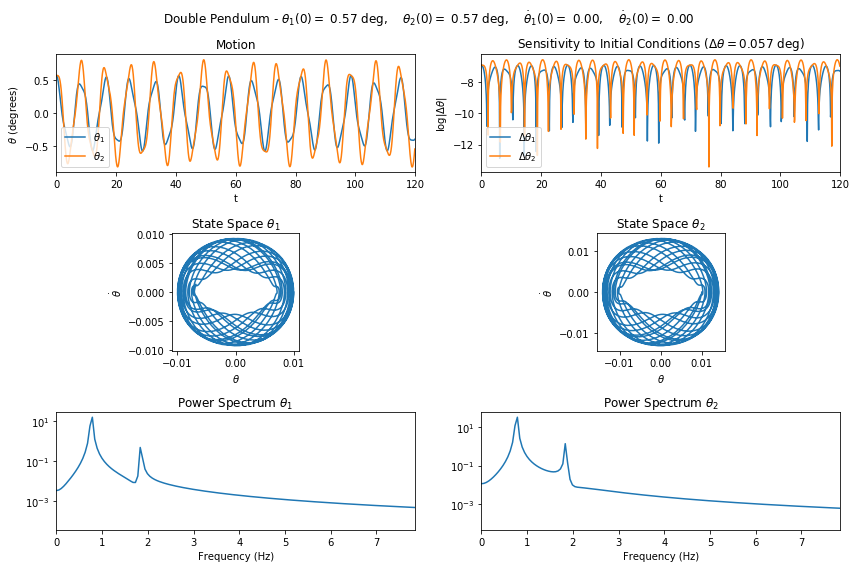

In [64]:
t_pts = np.arange(0., 120.0, 0.1)

theta_1_0 = theta_2_0 = 0.01
theta_1_dot_0 = theta_2_dot_0 = 0
initial_conditions = [theta_1_0, theta_2_0, theta_1_dot_0, theta_2_dot_0]

pend = DoublePendulum()
plot_pendulum(pend, t_pts, initial_conditions)

## Chaotic Motion

Next we will examine large initial angles. Looking back at the evidence for chaos, we expect the following:

- Sensitivity to Initial Conditions: A small separation in initial conditions should grow exponentially over time. 
- Power Spectrum: The power spectrum should be continuous.
- State Space Plots: The motion should not create a closed path.

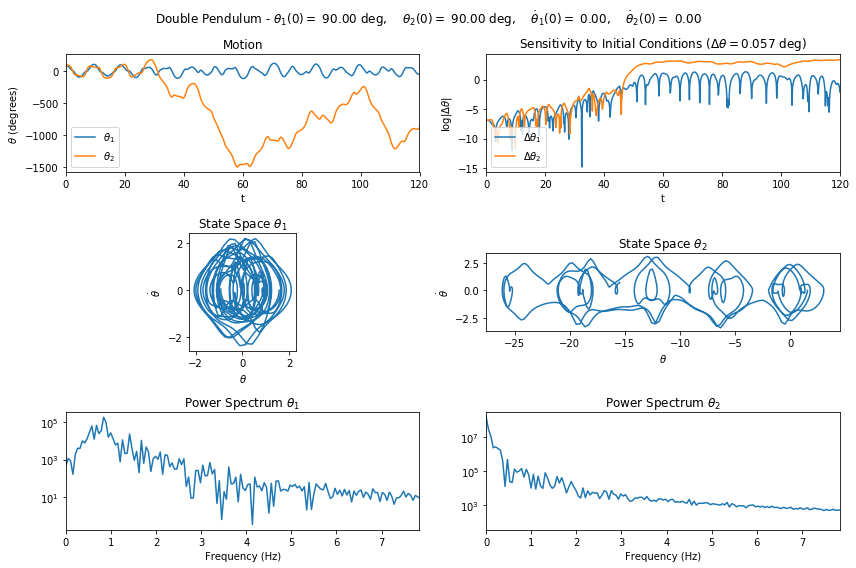

In [65]:
t_pts = np.arange(0., 120.0, 0.1)

theta_1_0 = theta_2_0 = np.pi / 2
theta_1_dot_0 = theta_2_dot_0 = 0
initial_conditions = [theta_1_0, theta_2_0, theta_1_dot_0, theta_2_dot_0]

pend = DoublePendulum()
plot_pendulum(pend, t_pts, initial_conditions)